In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2 as sql
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
dbname = 'thesoft_db'
user = 'server_api'
host = '192.168.100.152'
password = 'SunLight09+!'

Lifetime Value or LTV is an estimate of the average revenue that a customer will generate throughout their lifespan as a customer


In [3]:

conn = sql.connect(dbname=dbname, user=user, host=host, password=password)
cursor = conn.cursor()

query = """
        SELECT
            customer_customer."FULLNAME",
            customer_customer."CUSTOMER",
            policy_policy."OPENDATE" AS "FDATE",
            policy_policy."TODATE" AS "STOPDATE",
            policy_polrisk."PREMIUMS" AS "MAXPREMIUM"
        FROM
            policy_polrisk
        INNER JOIN policy_policy
            ON policy_polrisk."POLID_F" = policy_policy."ID"
        INNER JOIN polcont_polcont
            ON policy_policy."CONT_F" = polcont_polcont."CONT"
        INNER JOIN customer_customer
            ON polcont_polcont."CUSTOMER_F" = customer_customer."CUSTOMER"
            LIMIT 200;
"""

cursor.execute(query)
results = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
df = pd.DataFrame(results, columns=columns)

cursor.close()
conn.close()


In [4]:

#datatypey poxel, gtnel lifespany
df["FDATE"] = pd.to_datetime(df["FDATE"])
df["STOPDATE"] = pd.to_datetime(df["STOPDATE"])
df["lifespan"] = (df["STOPDATE"] - df["FDATE"]).dt.days

#anhrajesht arjeqnery LTV-n gtnelu hamar
income_per_customer = df.groupby('CUSTOMER')['MAXPREMIUM'].sum().reset_index()
lifespan_per_customer = df.groupby('CUSTOMER')['lifespan'].mean().reset_index()

#hashvel LTV-n
customer_ltv = pd.merge(income_per_customer, lifespan_per_customer, on='CUSTOMER')
customer_ltv['MAXPREMIUM'] = customer_ltv['MAXPREMIUM'].astype(float) #vor float cher error er berum bajaneluc
customer_ltv['LTV'] = customer_ltv['MAXPREMIUM'] / customer_ltv['lifespan']

#customernerin gtnel
info = df[['CUSTOMER', 'FULLNAME']].drop_duplicates()
customer_ltv = pd.merge(customer_ltv, info, on='CUSTOMER')

customer_ltv = customer_ltv[['CUSTOMER', 'FULLNAME', 'LTV']]

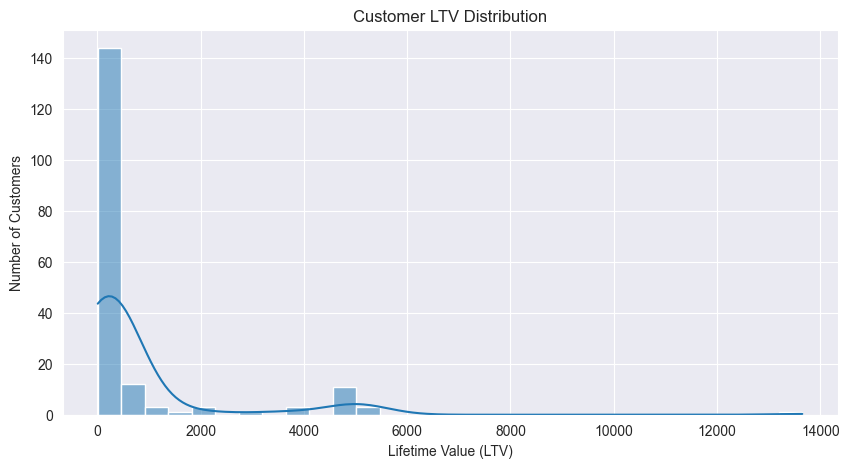

In [5]:
plt.figure(figsize=(10,5))
sns.histplot(customer_ltv['LTV'], bins=30, kde=True)
plt.xlabel("Lifetime Value (LTV)")
plt.ylabel("Number of Customers")
plt.title("Customer LTV Distribution")
plt.show()

In [7]:

#bajanel maseri
q1 = customer_ltv['LTV'].quantile(0.33)
q2 = customer_ltv['LTV'].quantile(0.66)

def segment_ltv(ltv):
    if ltv <= q1:
        return 'Low LTV'
    elif ltv <= q2:
        return 'Medium LTV'
    else:
        return 'High LTV'

customer_ltv['Segment'] = customer_ltv['LTV'].apply(segment_ltv)

low_ltv = customer_ltv[customer_ltv['Segment'] == 'Low LTV']
medium_ltv = customer_ltv[customer_ltv['Segment'] == 'Medium LTV']
high_ltv = customer_ltv[customer_ltv['Segment'] == 'High LTV']

#Tpel erkuakan customer amen segmentic
low_customers = customer_ltv[customer_ltv['Segment'] == 'Low LTV'][['FULLNAME', 'LTV']].head(2)
medium_customers = customer_ltv[customer_ltv['Segment'] == 'Medium LTV'][['FULLNAME', 'LTV']].head(2)
high_customers = customer_ltv[customer_ltv['Segment'] == 'High LTV'][['FULLNAME', 'LTV']].head(2)

print("Low LTV Customers:")
print(low_customers)

print("\nMedium LTV Customers:")
print(medium_customers)

print("\nHigh LTV Customers:")
print(high_customers)


Low LTV Customers:
                    FULLNAME        LTV
1              "Ադամանդ" ՍՊԸ  16.528926
2  "ՀՀ ԿԵՆՏՐՈՆԱԿԱՆ ԲԱՆԿ" Այլ  16.250000

Medium LTV Customers:
                       FULLNAME         LTV
4                 ԿԱՄՈ ՍԱՖԱՐՅԱՆ  362.637363
7  Հարությունյան Արտյոմ Գարուշի  362.637363

High LTV Customers:
                                             FULLNAME      LTV
0   ՀԱՅԱՍՏԱՆԻ ԱՄԵՐԻԿՅԱՆ ՀԱՄԱԼՍԱՐԱՆ ՀԻՄՆԱԴՐԱՄ Հիմնա...  13650.0
18                                      ԱՅՅՈՒՆԵԹՎՈՐՔՍ   5400.0


For High-value customers focus on retention strategies (e.g. loyalty programs, VIP offers)


Medium-value customers upsell/cross-sell campaigns to move them into the high-value segment

For Low-value customers  avoid over-investing in retention